In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import analysis.plotting as plotting
import analysis.analysis as analysis
import standard_sequences.pinopi as pnp


In [2]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
C1_address="GPIB0::6::INSTR"
C2_address="GPIB0::10::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_amp"],
    bnc_addr= bnc_address["TWPA_address"],
)

In [3]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

Qubit(ef_time=46, mixer_offset_ge=2.5, RO_LO_45=6.3804, ge_ssm=-0.117, RO_LO_pwr=16, ro_amp=0.3, RO_LO=6.6247, ef_half_amp=1.3, ge_time=77, ro_dur=5000, ge_amp=1, RO_IF=None, ef_ssm=-0.259, qubit_thr=[-10000, -600], mixer_offset_ef=6, ro_freq=6.72734, IQ_angle=60, RO_LO_34=6.4804, ef_half_time=25, qubit_id=q1, ef_amp=1.5, ROIF=0.10264000000000006)
Qubit(ef_time=None, mixer_offset_ge=2.5, RO_LO_45=6.3804, ge_ssm=-0.155, RO_LO_pwr=16, ro_amp=0.6, RO_LO=6.6247, ef_half_amp=None, ge_time=62, ro_dur=5000, ge_amp=1, RO_IF=None, ef_ssm=-0.2962, qubit_thr=[-10000, 1900], mixer_offset_ef=None, ro_freq=6.6554, IQ_angle=25, RO_LO_34=6.4804, ef_half_time=None, qubit_id=q2, ef_amp=1, ROIF=0.030700000000000394)


In [4]:
def make_hist(IQdata, ax_hist,labelstr):
    binwidth = 200
    lim_IQ_min = np.min([IQdata])
    lim_IQ_max = np.max([IQdata])
    
    bins_IQ = np.arange(lim_IQ_min, lim_IQ_max, binwidth)
    
    counts_IQ = ax_hist.hist(IQdata, bins=bins_IQ, histtype='step', orientation='vertical', label = labelstr)[0]
    
    gauss_xaxis = np.linspace(lim_IQ_min,lim_IQ_max, len(counts_IQ))
    
    
    return bins_IQ,counts_IQ, gauss_xaxis


def plot_hist_and_fit(data_g, data_e, label_g, label_e, axis_label):
    ax = plt.axes()
    print(f"{axis_label} histogram")
    bins_g, counts_g, gauss_x_g = make_hist(data_g, ax, label_g)
    bins_e, counts_e, gauss_x_e = make_hist(data_e, ax, label_e)
    _, mu_g, std_g = analysis.fit_gaussian_no_plot(data_g, gauss_x_g, counts_g, ax)
    _, mu_e, std_e = analysis.fit_gaussian_no_plot(data_e, gauss_x_e, counts_e, ax)
    ax.legend()
    plt.show()
    return mu_g, std_g, mu_e, std_e



In [5]:
def run_pi_no_pi(q1, q2, general_vals_dict,num_steps, reps):
    # pnp.pi_nopi_ge(0, 0, q2, q1, general_vals_dict)
    # pnp.pi_nopi_ge(1, 1, q2, q1, general_vals_dict)

    pnp.pi_nopi_ef(0, 0, 0, q1, q2, general_vals_dict)
    pnp.pi_nopi_ef(1, 1, 1, q1, q2, general_vals_dict)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )
    return values

def get_snr(q1, q2, general_vals_dict,num_steps, reps):
    values= run_pi_no_pi(q1, q2, general_vals_dict,num_steps, reps) 
    mu_Ig, std_Ig, mu_Ie, std_Ie = plot_hist_and_fit(
        values.rec_readout_vs_pats_1[0, :, 0],  # Ig
        values.rec_readout_vs_pats_1[0, :, 1],  # Ie
        'Ig', 'Ie', 'I'
    )

    # Plot and fit Q quadrature
    mu_Qg, std_Qg, mu_Qe, std_Qe = plot_hist_and_fit(
        values.rec_readout_vs_pats_1[1, :, 0],  # Qg
        values.rec_readout_vs_pats_1[1, :, 1],  # Qe
        'Qg', 'Qe', 'Q'
    )

    # Calculate SNR
    signal = np.sqrt((mu_Ig - mu_Ie) ** 2 + (mu_Qg - mu_Qe) ** 2)
    noise = np.mean([np.abs(std_Ig), np.abs(std_Qg), np.abs(std_Ie), np.abs(std_Qe)])
    SNR = signal / noise

    print("SNR:", SNR)
    return SNR

In [6]:
def sweep_ro_freq(sweep_list):
    num_steps=3
    reps=15000
    SNR_list = []
    for freq in sweep_list:
        q1.ROIF = freq-readout_dict["RO_LO"]
        SNR = get_snr(q1, q2, general_vals_dict,num_steps, reps)
        SNR_list.append(SNR)
    return SNR_list

def sweep_ro_amp(sweep_list):
    num_steps=3
    reps=5000
    SNR_list = []
    for amp in sweep_list:
        q1.ro_amp = amp
        SNR = get_snr(q1, q2, general_vals_dict,num_steps, reps)
        SNR_list.append(SNR)
    return SNR_list

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 9.915339 sec
Captured 15 buffers (1.512808 buffers per sec)
Captured 46080 records (46

<Figure size 800x800 with 0 Axes>

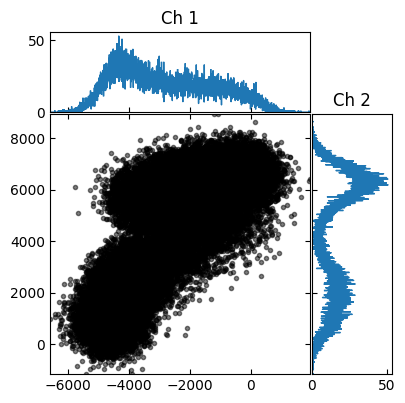

<Figure size 800x800 with 0 Axes>

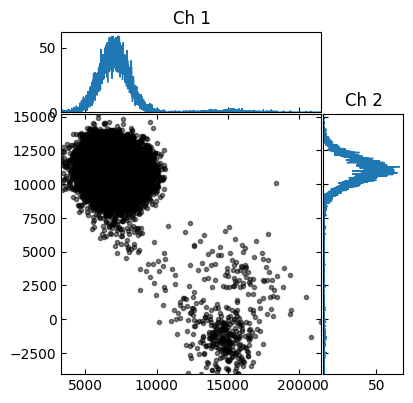

I histogram


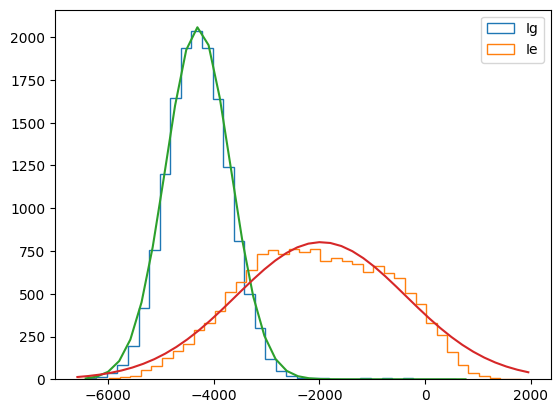

Q histogram


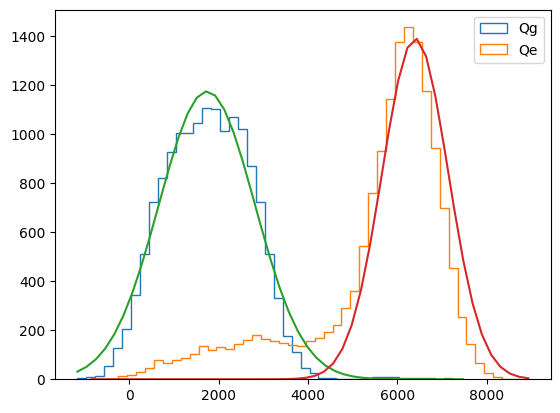

SNR: 5.159698203532937
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 9.927941 sec
Captured 15 buffers (1.510887 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

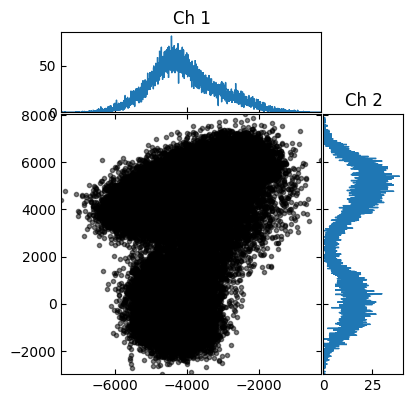

<Figure size 800x800 with 0 Axes>

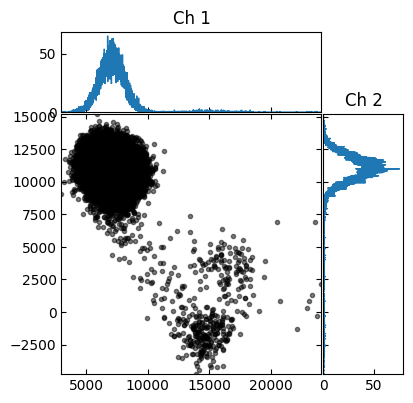

I histogram


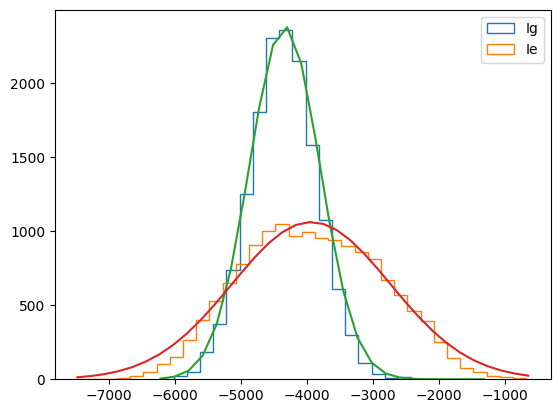

Q histogram


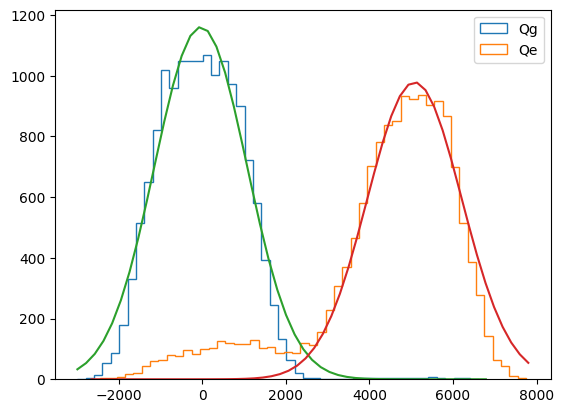

SNR: 5.168784406381212
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 9.900607 sec
Captured 15 buffers (1.515059 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

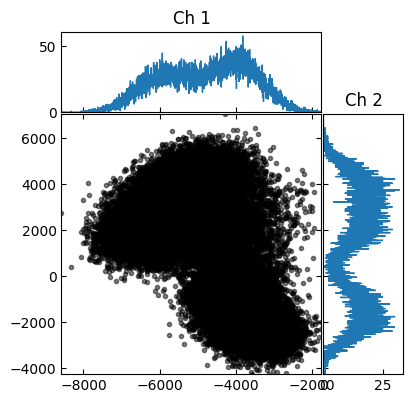

<Figure size 800x800 with 0 Axes>

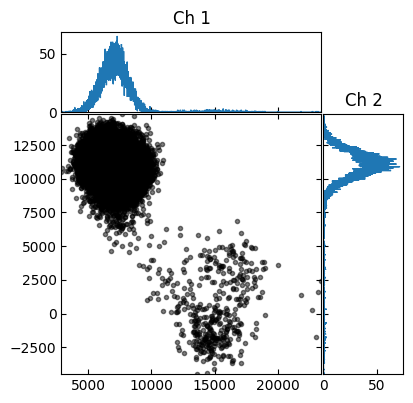

I histogram


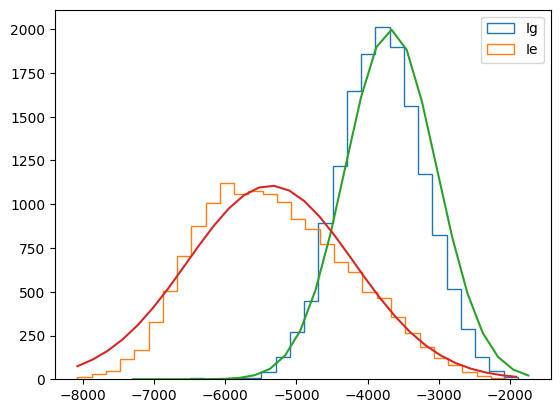

Q histogram


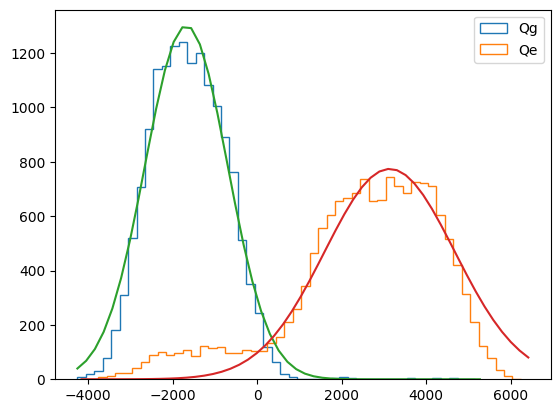

SNR: 4.720437254055009
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 9.945524 sec
Captured 15 buffers (1.508216 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

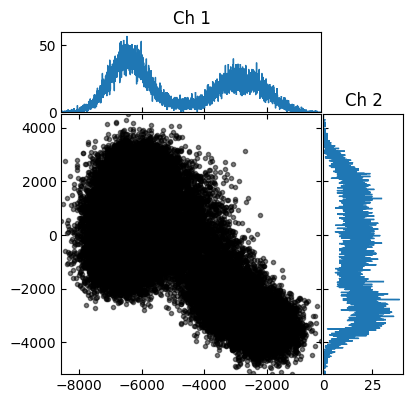

<Figure size 800x800 with 0 Axes>

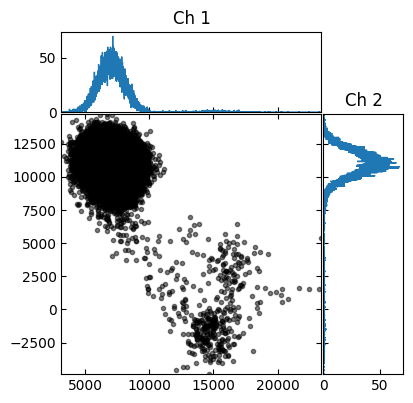

I histogram


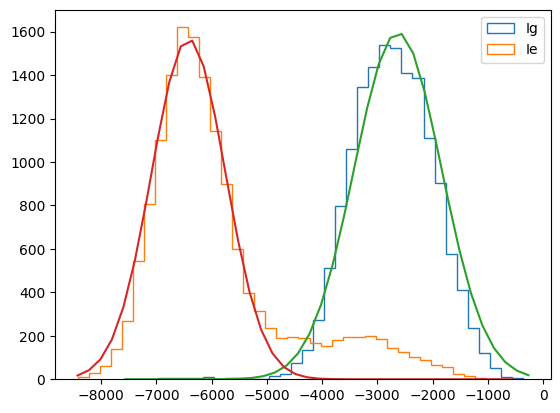

Q histogram


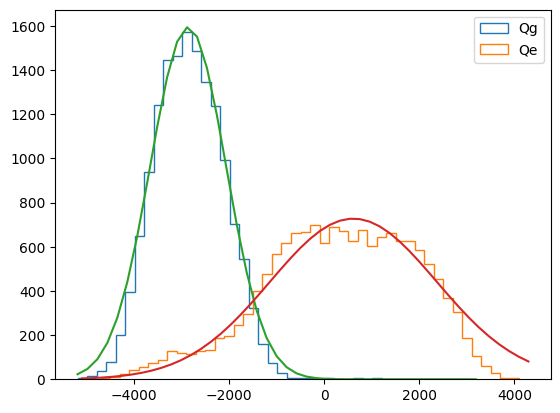

SNR: 5.120644750765813
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 9.952731 sec
Captured 15 buffers (1.507124 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

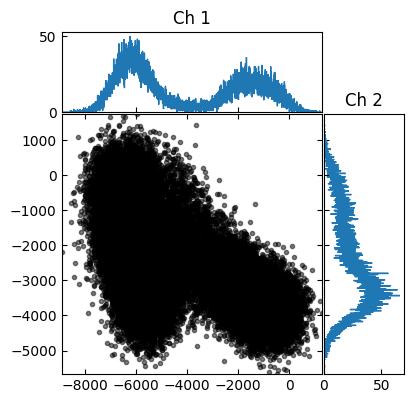

<Figure size 800x800 with 0 Axes>

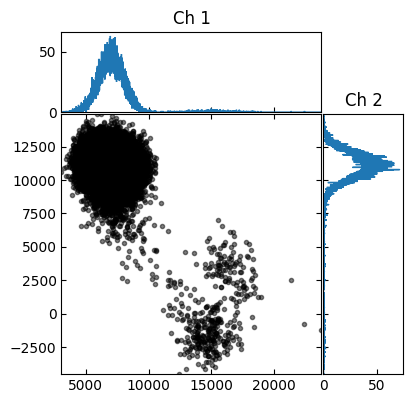

I histogram


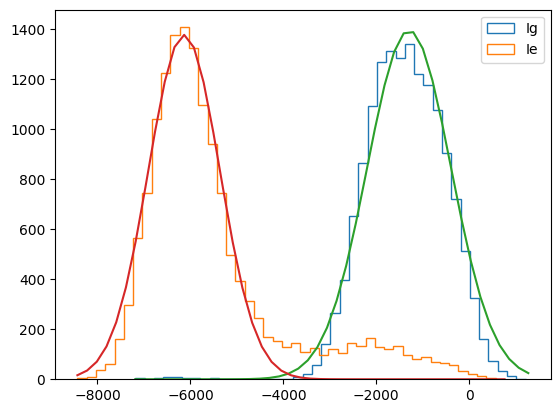

Q histogram


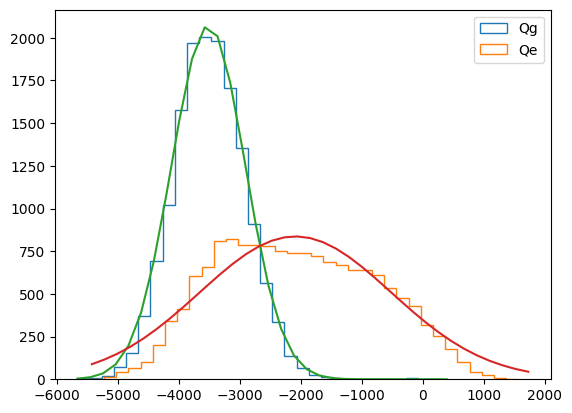

SNR: 5.237797469987508
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 9.913980 sec
Captured 15 buffers (1.513015 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

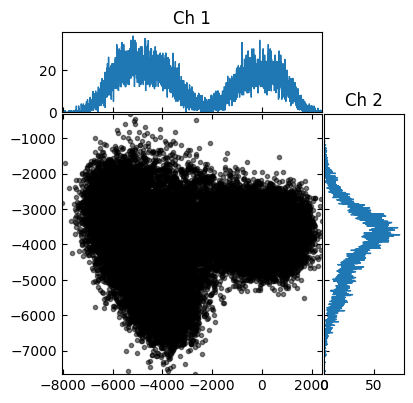

<Figure size 800x800 with 0 Axes>

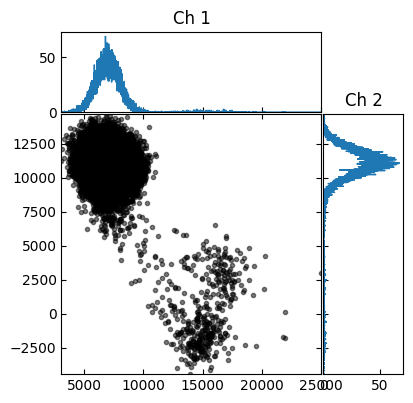

I histogram


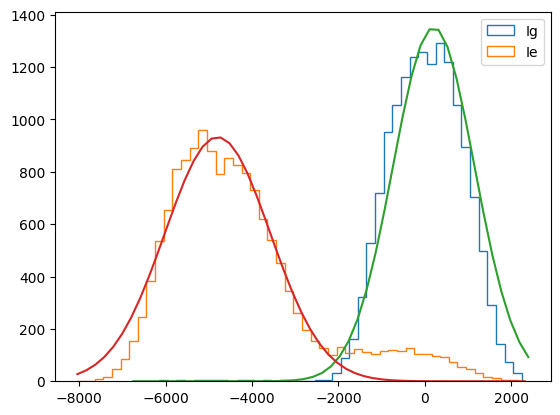

Q histogram


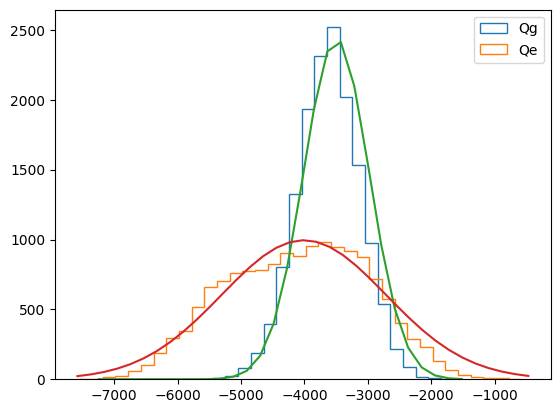

SNR: 5.054229974103807
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 9.984046 sec
Captured 15 buffers (1.502397 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

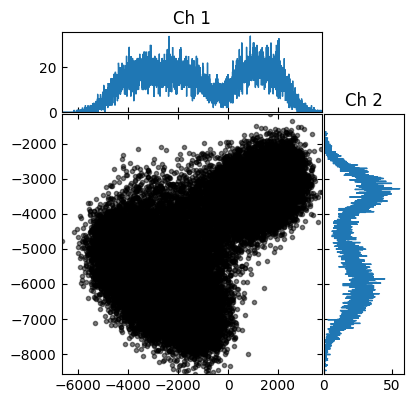

<Figure size 800x800 with 0 Axes>

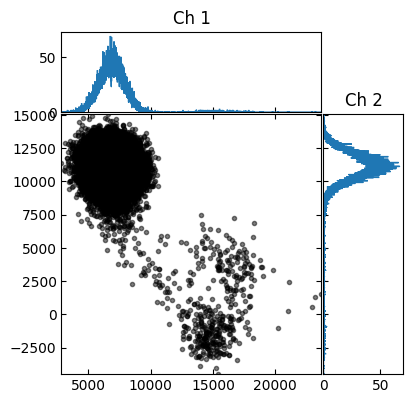

I histogram


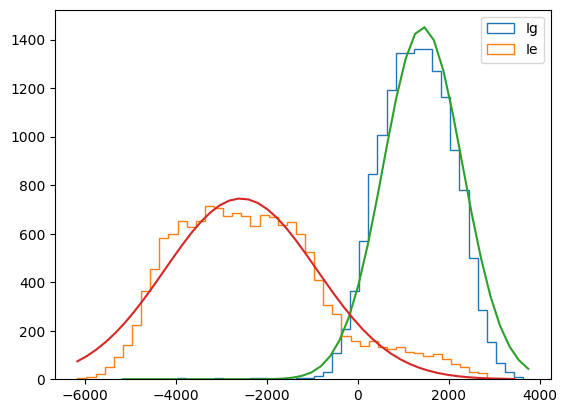

Q histogram


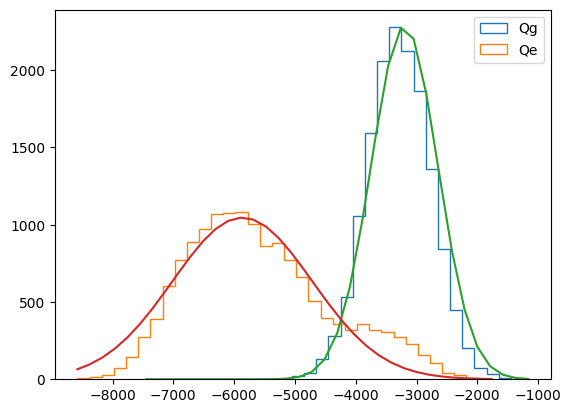

SNR: 4.534800424648108
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 10.069664 sec
Captured 15 buffers (1.489623 buffers per sec)
Ca

<Figure size 800x800 with 0 Axes>

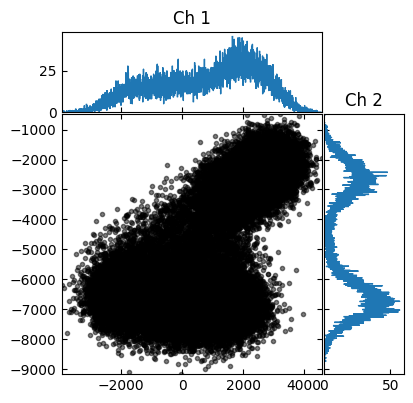

<Figure size 800x800 with 0 Axes>

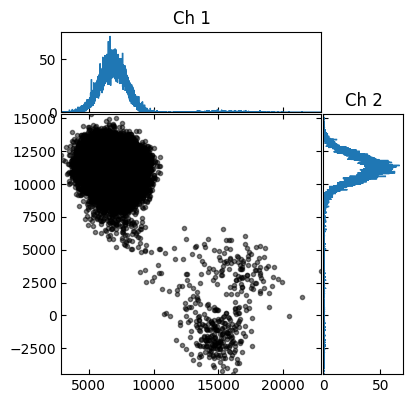

I histogram


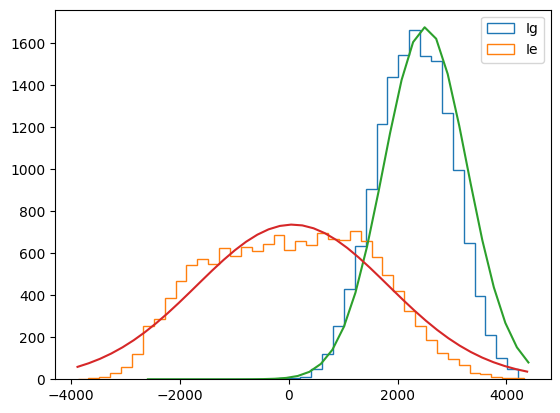

Q histogram


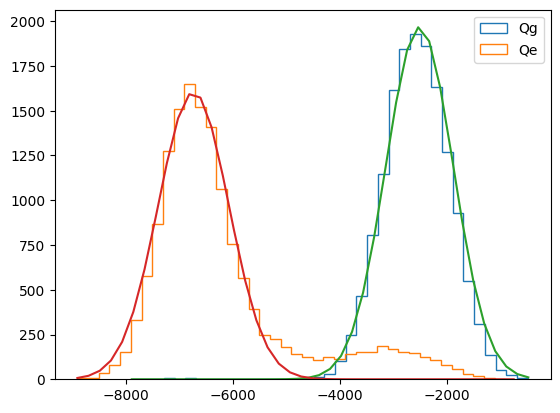

SNR: 5.115260474080921
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 9.908259 sec
Captured 15 buffers (1.513889 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

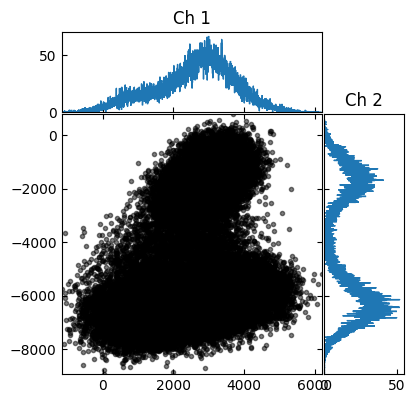

<Figure size 800x800 with 0 Axes>

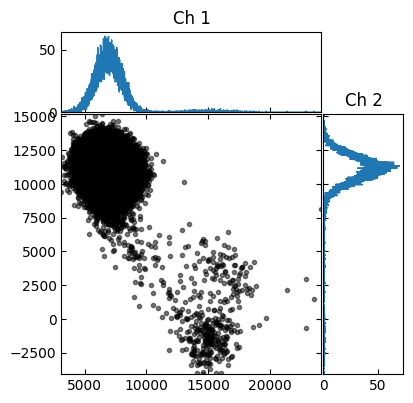

I histogram


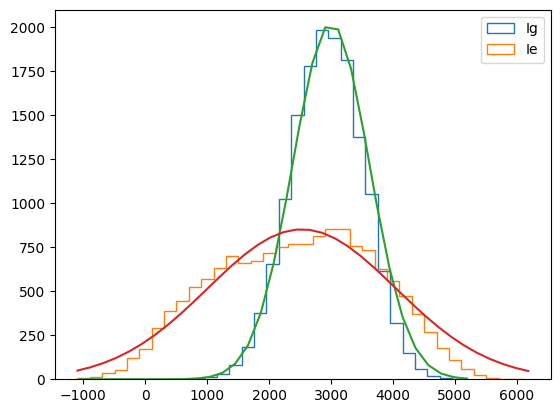

Q histogram


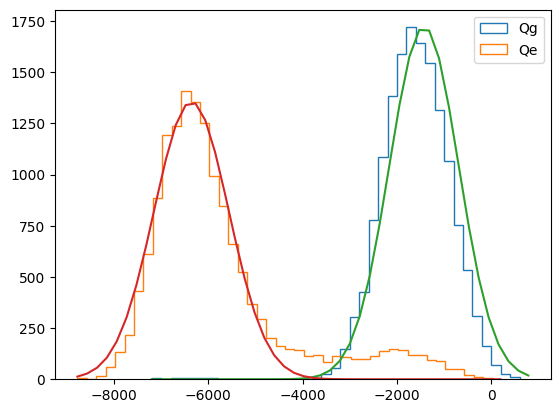

SNR: 5.405807008765389
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 9.941157 sec
Captured 15 buffers (1.508879 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

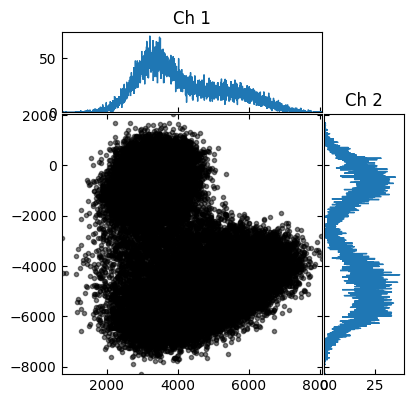

<Figure size 800x800 with 0 Axes>

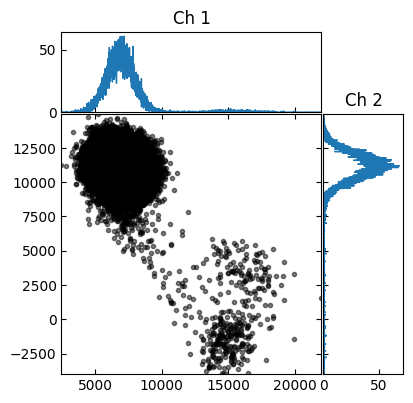

I histogram


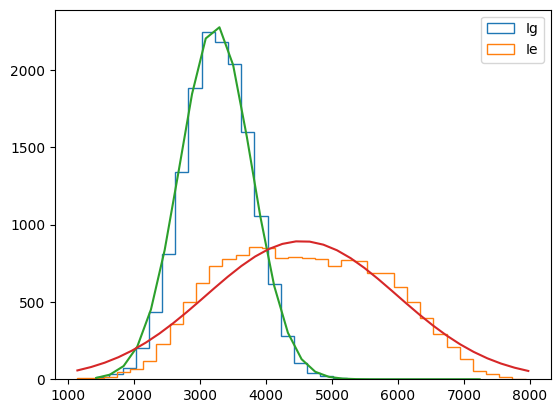

Q histogram


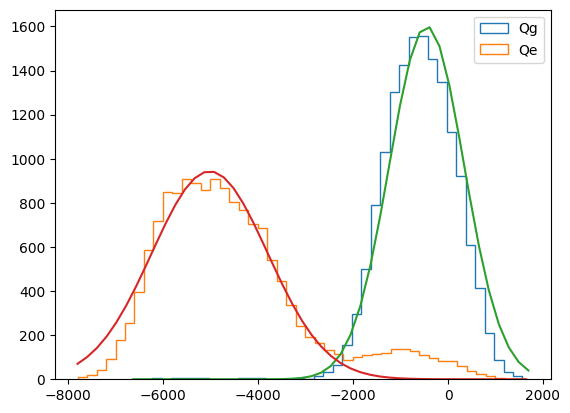

SNR: 4.747379056703901
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 9.929874 sec
Captured 15 buffers (1.510593 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

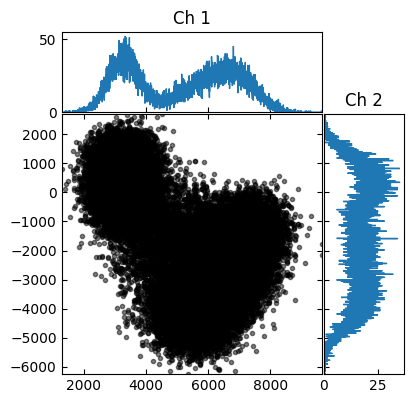

<Figure size 800x800 with 0 Axes>

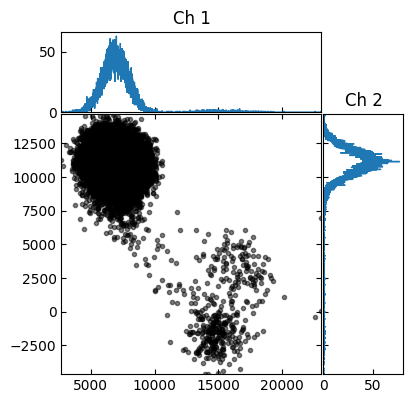

I histogram


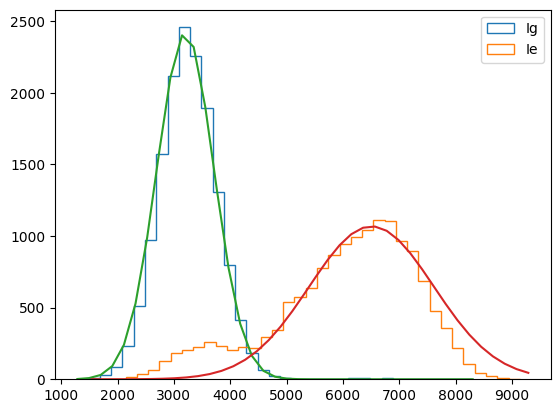

Q histogram


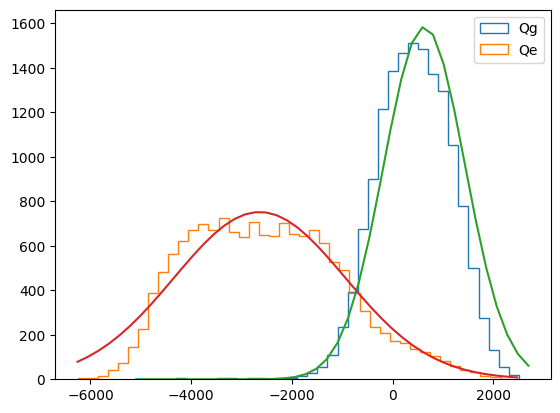

SNR: 4.50824145944288


In [9]:
# num_steps=3
# reps=15000

# SNR = get_snr(q1, q2, general_vals_dict,num_steps, reps)
freq_start = 6.7273
freq_stop = 6.7274
freq_steps=11
freq_list = np.linspace(freq_start, freq_stop, freq_steps)
SNR_list = sweep_ro_freq(freq_list)
# amp_start = 0
# amp_stop = .5
# amp_steps=21
# amp_list = np.linspace(amp_start, amp_stop, amp_steps)
# SNR_list = sweep_ro_amp(amp_list)


In [8]:
plt.plot(amp_list, SNR_list)
plt.xlabel("RO amp")
plt.ylabel("SNR")
plt.title("SNR vs RO amp")
plt.show()

NameError: name 'amp_list' is not defined

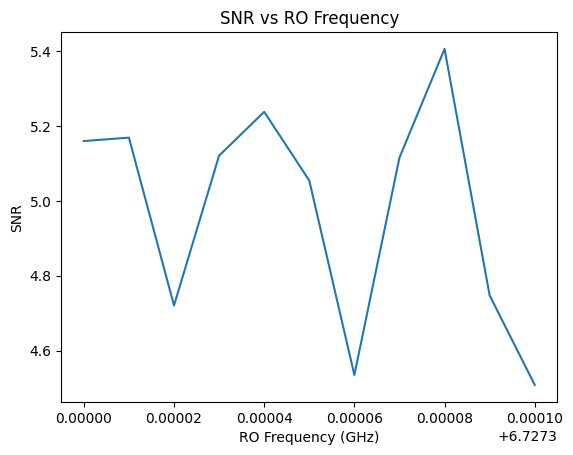

Maximum SNR: 5.40581 at frequency: 6.727380 GHz


In [10]:
plt.plot(freq_list, SNR_list)
plt.xlabel("RO Frequency (GHz)")
plt.ylabel("SNR")
plt.title("SNR vs RO Frequency")
plt.show()
max_idx = np.argmax(SNR_list)
max_freq =freq_list[max_idx]
max_snr = SNR_list[max_idx]

print(f"Maximum SNR: {max_snr:.5f} at frequency: {max_freq:.6f} GHz")